```1. Merging data```

In [1]:
import pandas as pd

# Load the data
time_series_data = pd.read_csv('C:/Users/woras/OneDrive/Desktop/Paper_IoT/Final_Spring_Wheat_Weather.csv')
ground_truth_data = pd.read_excel('C:/Users/woras/OneDrive/Desktop/Paper_IoT/GT_spring_wheat.xlsx')

# Filter the ground truth data to include only rows where Plot Area equals 80
filtered_ground_truth_data = ground_truth_data[ground_truth_data['Plot Area'] == 80]

# Merge the filtered ground truth data with the time series data based on 'variety' and 'rep_var' columns
merged_data = pd.merge(time_series_data, filtered_ground_truth_data, how='inner', left_on=['variety', 'rep_var'], right_on=['variety', 'rep_var'])

# Save the merged data to a CSV file
merged_data.to_csv('C:/Users/woras/OneDrive/Desktop/Paper_IoT/Output/1_merged_spring_wheat_data.csv', index=False)


```2. Segment the growth period```

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to convert Julian day to datetime
def julian_to_date(year, julian_day):
    return pd.to_datetime(f'{year}-01-01') + pd.Timedelta(days=julian_day - 1)

# Define the date ranges for each growth stage
def define_growth_stages():
    return {
        'Establishment': (90, 105),  # Julian days 90-105 (early April)
        'Vegetative Growth': (106, 160),  # Julian days 106-160 (mid-April to early June)
        'Reproductive Development': (161, 200),  # Julian days 161-200 (early June to mid-July)
        'Grain Filling and Maturity': (201, 232)  # Julian days 201-232 (mid-July to mid-August)
    }
# Function to convert Julian day to datetime within a year
def convert_julian_to_datetime(year, julian_day):
    return pd.to_datetime(f'{year}-01-01') + pd.Timedelta(days=julian_day - 1)

# Load data
merged_data = pd.read_csv('C:/Users/woras/OneDrive/Desktop/Paper_IoT/Output/1_merged_spring_wheat_data.csv')
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Convert heading date from Julian to datetime
merged_data['Heading date'] = merged_data['Heading date'].apply(lambda x: julian_to_date(2022, x))

# Data Cleaning
# 1.Remove duplicates
merged_data.drop_duplicates(inplace=True)

# 2.Handle missing values
merged_data.dropna(inplace=True)

# 3.Ensure correct data types
for col in merged_data.columns:
    if merged_data[col].dtype == 'object':
        try:
            merged_data[col] = pd.to_numeric(merged_data[col])
        except ValueError:
            pass

# 4.Optional: Filter outliers in the 'mean' column
if 'mean' in merged_data.columns:
    Q1 = merged_data['mean'].quantile(0.25)
    Q3 = merged_data['mean'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (merged_data['mean'] >= (Q1 - 1.5 * IQR)) & (merged_data['mean'] <= (Q3 + 1.5 * IQR))
    merged_data = merged_data[filter]

# 5.Remove rows where 'vi' column is 'cigreen' or 'ndvi'
merged_data = merged_data[~merged_data['vi'].isin(['cigreen', 'gndvi'])]

# 6.Rename 'cigreen0' to 'CI_GREEN' and 'ndvi0' to 'NDVI'
merged_data['vi'] = merged_data['vi'].replace({'cigreen0': 'CI_GREEN', 'gndvi0': 'GNDVI'})

# 7.Convert all text in 'vi' column to uppercase
merged_data['vi'] = merged_data['vi'].str.upper()

# Create a list to hold segmented data with an additional 'Stage' column
segmented_data_list = []

# Segment data based on growth stages
growth_stages = define_growth_stages()
for idx, row in merged_data.iterrows():
    for stage, (start_day, end_day) in growth_stages.items():
        start_date = convert_julian_to_datetime(2022, start_day)
        end_date = convert_julian_to_datetime(2022, end_day)
        if start_date <= row['date'] <= end_date:
            row_copy = row.copy()
            row_copy['Stage'] = stage
            segmented_data_list.append(row_copy)

# Create DataFrame from the list
segmented_data = pd.DataFrame(segmented_data_list)

# Save the combined segmented data to a single file
file_name = 'C:/Users/woras/OneDrive/Desktop/Paper_IoT/Output/2_segmented_data.csv'
segmented_data.to_csv(file_name, index=False)

print('Combined segmented dataset has been saved as 2_segmented_data.csv.')

Combined segmented dataset has been saved as 2_segmented_data.csv.


```2.1 Show the segmented figure```

C:\Users\woras\AppData\Local\Temp\ipykernel_492\2991848731.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_data['date_numeric'] = pd.to_datetime(filtered_combined_data['date']).astype('int64') // 10**9  # Convert to seconds


Calculated AUC: 2245089.31


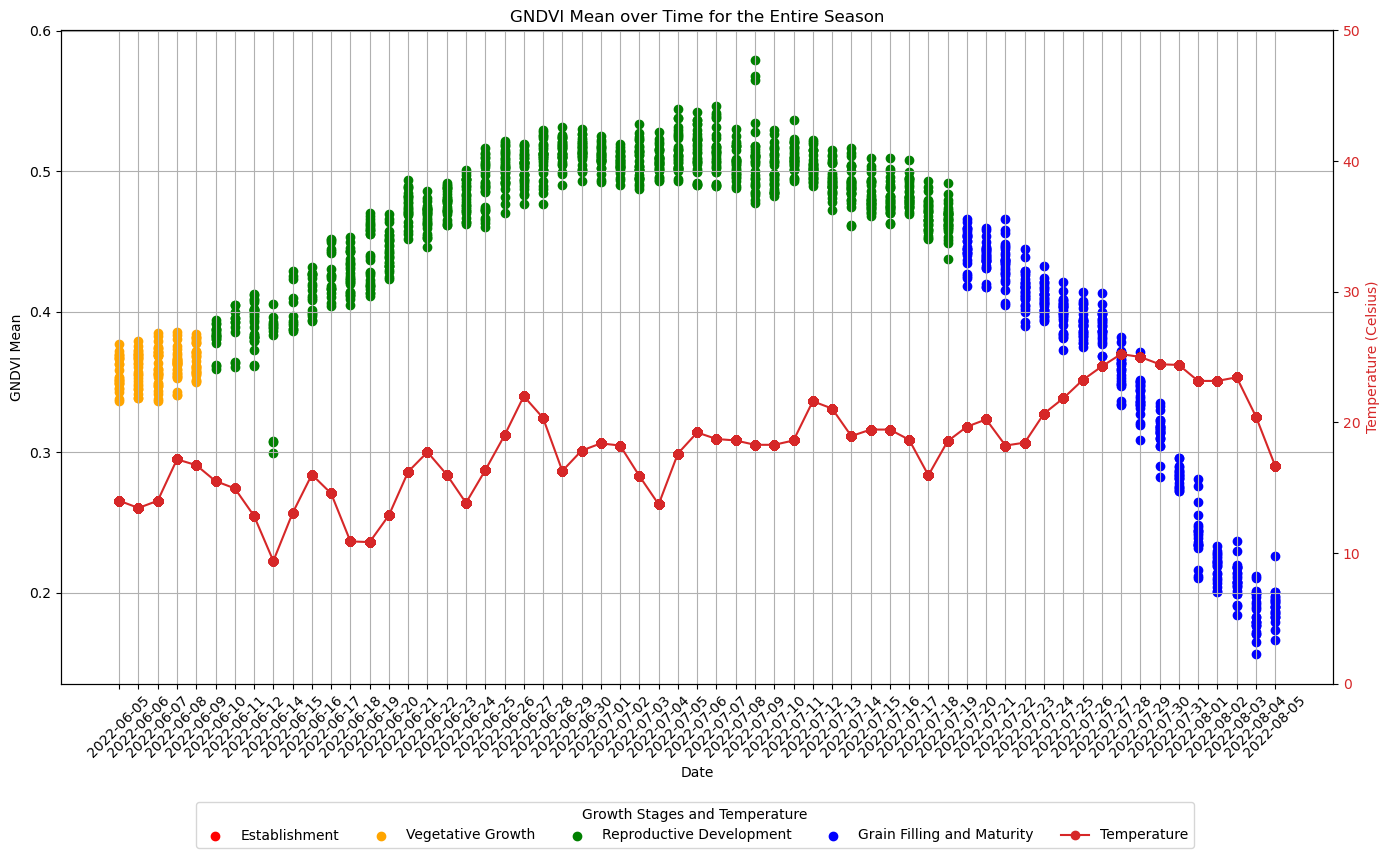

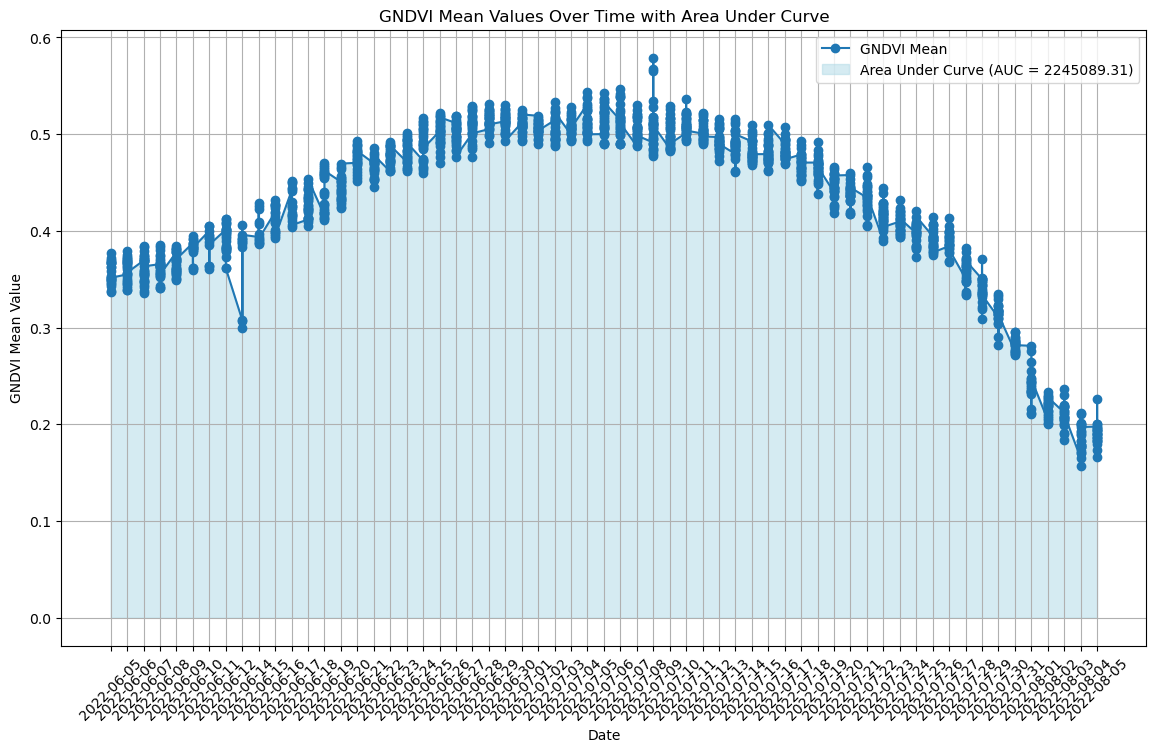

Calculated AUC: 2245089.31


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import trapz

# Load the segmented dataset
# Replace with the actual path to your file
segmented_data = pd.read_csv('C:/Users/woras/OneDrive/Desktop/Paper_IoT/Output/2_segmented_data.csv')

# Sort the combined segmented data by date
segmented_data.sort_values(by='date', inplace=True)

# Filter the combined data for the selected vegetation index (VI)
vi_type = 'GNDVI'  # Example VI type after renaming
filtered_combined_data = segmented_data[segmented_data['vi'] == vi_type]

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Define colors for each growth stage
growth_stage_colors = {
    'Establishment': 'red',
    'Vegetative Growth': 'orange',
    'Reproductive Development': 'green',
    'Grain Filling and Maturity': 'blue'
}

# Plot the VI data over time for the entire season with color-coded dots for each growth stage
for stage, color in growth_stage_colors.items():
    stage_data = filtered_combined_data[filtered_combined_data['Stage'] == stage]
    ax1.scatter(stage_data['date'], stage_data['mean'], color=color, label=stage)

# Customize the plot
ax1.set_xlabel('Date')
ax1.set_ylabel(f'{vi_type} Mean')
ax1.set_title(f'{vi_type} Mean over Time for the Entire Season')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for the temperature data
ax2 = ax1.twinx()
ax2.set_ylabel('Temperature (Celsius)', color='tab:red')
ax2.plot(segmented_data['date'], segmented_data['air_temp'], color='tab:red', linestyle='-', marker='o', label='Temperature')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 50)  # Set the y-axis range for temperature

# Move legend to a lower position and adjust to 4 vertical columns
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.075), ncol=5, title='Growth Stages and Temperature')

# Tight layout for better spacing
fig.tight_layout()

# Calculate the AUC for GNDVI using the trapezoidal rule
# First, convert the 'date' column to datetime, then to int64 for numerical operations
filtered_combined_data['date_numeric'] = pd.to_datetime(filtered_combined_data['date']).astype('int64') // 10**9  # Convert to seconds

# Extract numeric timepoints and GNDVI mean values
timepoints_numeric = filtered_combined_data['date_numeric'].values
gndvi_values = filtered_combined_data['mean'].values

# Calculate AUC using the trapezoidal rule
auc_value = trapz(gndvi_values, x=timepoints_numeric)

# Print the AUC value
print(f"Calculated AUC: {auc_value:.2f}")

# Plot the AUC shading (based on GNDVI mean values)
plt.figure(figsize=(14, 8))
plt.plot(filtered_combined_data['date'], gndvi_values, marker='o', linestyle='-', label='GNDVI Mean')
plt.fill_between(filtered_combined_data['date'], gndvi_values, color='lightblue', alpha=0.5, label=f'Area Under Curve (AUC = {auc_value:.2f})')

# Customize the AUC plot
plt.title('GNDVI Mean Values Over Time with Area Under Curve')
plt.xlabel('Date')
plt.ylabel('GNDVI Mean Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the AUC plot
plt.show()

# Print the calculated AUC value
print(f"Calculated AUC: {auc_value:.2f}")
